In [9]:
# Imports
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from testing_functions import test_hss
from process_functions import preprocessing_audio
from utils import find_and_open_audio, signal_segmentation, get_resp_segments
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, \
    upsampling_signal
from source_separation.descriptor_functions import get_spectrogram
from IPython.display import Audio
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [10]:
# Dirección de la base de datos
db_folder = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

# Definición de la frecuencia de muestreo deseada para 
# separación de fuentes
samplerate_nmf = 11025 # Hz
samplerate_cls = 4000  # Hz

In [11]:
len(filenames)

790

# Preprocesamiento

In [12]:
def _conditioning_signal(signal_in, samplerate, samplerate_to):
    # Acondicionando en caso de que no tenga samplerate de 1000 Hz.
    if samplerate < samplerate_to:
        print(f'Upsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.') 
        new_rate = samplerate_to           
        audio_to = upsampling_signal(signal_in, samplerate, new_samplerate=new_rate)

    elif samplerate > samplerate_to:
        print(f'Downsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.')
        new_rate, audio_to = downsampling_signal(signal_in, samplerate, 
                                                 freq_pass=samplerate_to//2-100, 
                                                 freq_stop=samplerate_to//2)

    else:
        print(f'Samplerate adecuado a fs = {samplerate} Hz.')
        audio_to = signal_in
        new_rate = samplerate_to

    # Mensaje para asegurar
    print(f'Señal acondicionada a {new_rate} Hz para la separación de fuentes.')

    # Asegurándose de que el largo de la señal sea par
    if len(audio_to) % 2 != 0:
        audio_to = np.concatenate((audio_to, [0]))

    return audio_to, new_rate

In [13]:
# Parámetros utilizados para el preprocesamiento
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}       # None
model_name = 'definitive_segnet_based'

# Definición de los parámetros NMF
nmf_method = 'replace_segments'
N = 1024
nmf_parameters = {'n_components': 10, 'N': N, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * N), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 2, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'temp_criterion'}

# Parámetros de los descriptores
n_mfcc = 13
N = 1024
noverlap = int(0.75 * N)
window = 'hann'

In [15]:
%matplotlib notebook

# Definición de los arrays donde se acumulará las características
X_data = list()
# Definición de los arrays donde se acumularán las etiquetas
Y_wheeze = list()
Y_crackl = list()

# Parámetros
preprocess = False
# Decisión de características
mfcc_bool = True
psd_bool = False


# Método de colapso
collapse_mfcc = 'max'


# Nombre del archivo .wav a utilizar
for num, name in enumerate(filenames):
    print(f'Iteración {num + 1}')
    print(f'-------------')
    
    filename = f'{db_folder}/{name}'

    # Cargando el archivo
    try:
        samplerate, audio = wavfile.read(f'{filename}.wav')
    except:
        audio, samplerate = sf.read(f'{filename}.wav')
    
    
    # Normalizando
    audio = audio / max(abs(audio))
    
    if preprocess:
        if samplerate == 44100:
            # Aplicando preprocesamiento
            resp_signal, heart_signal = \
                    preprocessing_audio(audio, samplerate, model_name, lowpass_params,
                                        nmf_parameters, nmf_method=nmf_method,
                                        filter_parameters={'bool': False},
                                        plot_segmentation=False,
                                        plot_separation=False)

            # Aplicando downsampling a 4000 Hz
            if samplerate == 44100:
                resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, samplerate)
                resp_to, _ = _conditioning_signal(resp_to, samplerate, samplerate_cls)
            else:
                continue
                resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, samplerate_cls)
        
        else:
            continue
        
    else:
        resp_to, _ = _conditioning_signal(audio, samplerate, samplerate_cls)
    
    
    # Obteniendo la información de los segmentos de este archivo de audio
    resp_list_info = get_resp_segments(resp_to, samplerate_cls, 
                                       filepath=f'{filename}.txt')
    
    print(resp_to.shape, audio.shape)
    
    # Para cada segmento, se obtiene la información de interés
    for resp_info in resp_list_info[:-1]:
        # Definición de la lista de características a agregar
        features_to_append = list()
        
        # Calculando las características a partir del segmento
        if mfcc_bool:
            mfcc = librosa.feature.mfcc(y=resp_info[0], sr=samplerate_cls, n_mfcc=n_mfcc)

            # Resumiendo
            if collapse_mfcc == 'mean':
                mfcc_collapsed = mfcc.mean(axis=1)
            elif collapse_mfcc == 'max':
                mfcc_collapsed = mfcc.max(axis=1)
            
            # Agregando a la lista de características
            features_to_append.extend(mfcc_collapsed)
        
        if psd_bool:
            _, psd_to = signal.welch(x=resp_info[0], fs=samplerate_cls, window=window, 
                                     nperseg=N, noverlap=noverlap, nfft=N)
            
            # Agregando a la lista de características
            features_to_append.extend(psd_to)
        
        # Agregando la información a cada arreglo
        X_data.append(features_to_append)
        Y_wheeze.append(resp_info[1])
        Y_crackl.append(resp_info[2])
        
        
#         # Espectrogrma
#         plt.figure()
#         plt.subplot(1,2,1)
#         plt.plot(resp_info[0])

#         t, f, S = get_spectrogram(resp_info[0], samplerate_cls, N=1024, 
#                                   padding=1024, repeat=0, noverlap=768, 
#                                   window='hann', whole=False)

#         plt.subplot(1,2,2)
#         plt.pcolormesh(t, f, 20 * np.log10(abs(S)), cmap='jet')
#         plt.show()
        


# Transformando listas a arrays
X_data = np.array(X_data)
Y_wheeze = np.array(Y_wheeze)
Y_crackl = np.array(Y_crackl)

Iteración 1
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 2
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 3
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 4
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 5
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(63424,) (63424,)
Iteración 6
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(102336,) (102336,)
Iteración 7
-------------
Samplerate adecuado a fs = 4000 Hz

Señal acondicionada a 4000 Hz para la separación de fuentes.
(120000,) (120000,)
Iteración 54
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(58304,) (58304,)
Iteración 55
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(62912,) (62912,)
Iteración 56
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(83392,) (83392,)
Iteración 57
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(58304,) (58304,)
Iteración 58
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(78528,) (78528,)
Iteración 59
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(87744,) (87744,)
Iteración 60
-------------
Downsampling de la señal de fs = 44100 H

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1316
  n_fft, y.shape[-1]


Iteración 66
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882001,)
Iteración 67
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(61888,) (61888,)
Iteración 68
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(73408,) (73408,)
Iteración 69
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(50112,) (50112,)
Iteración 70
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80320,) (80320,)
Iteración 71
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(49856,) (49856,)
Iteración 72
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1600
  n_fft, y.shape[-1]


Iteración 93
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80062,) (880677,)
Iteración 94
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 95
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 96
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 97
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 98
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 143
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 144
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 145
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 146
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 147
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 148
-------------
Down

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1716
  n_fft, y.shape[-1]


Iteración 174
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 175
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 176
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 177
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 178
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 179
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iter

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 225
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 226
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 227
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 228
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80102,) (881118,)
Iteración 229
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 230
-------------
Down

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1368
  n_fft, y.shape[-1]


Iteración 261
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 262
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 263
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=912
  n_fft, y.shape[-1]


Iteración 264
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1772
  n_fft, y.shape[-1]


Iteración 265
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 266
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 267
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 268
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 269
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 270
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iter

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 315
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 316
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 317
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 318
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 319
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 320
-------------
Down

-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 365
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 366
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 367
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 368
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 369
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 370
----

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(79500,) (874503,)


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2040
  n_fft, y.shape[-1]


Iteración 414
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 415
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 416
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(248200,) (248200,)
Iteración 417
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(248200,) (248200,)
Iteración 418
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(231200,) (231200,)
Iteración 419
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(250000,) (250000,)
Iteración 420
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 40

(80182,) (882000,)
Iteración 464
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 465
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 466
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 467
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 468
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 469
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(801

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1544
  n_fft, y.shape[-1]


Iteración 472
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 473
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 474
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 475
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 476
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 477
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iter

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 523
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 524
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 525
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 526
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 527
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 528
-------------
Down

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 573
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 574
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 575
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 576
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 577
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 578
-------------
Down

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1656
  n_fft, y.shape[-1]


Iteración 587
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2000
  n_fft, y.shape[-1]


Iteración 588
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 589
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 590
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 591
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 592
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 593
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iter

-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 639
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 640
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 641
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 642
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 643
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 644
----

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 688
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 689
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 690
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 691
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 692
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 693
-------------
Down

Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 737
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 738
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 739
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 740
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 741
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 742
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Seña

Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 788
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 789
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)
Iteración 790
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
(80182,) (882000,)


In [16]:
# Transformando listas a arrays
X_data = np.array(X_data)
Y_wheeze = np.array(Y_wheeze)
Y_crackl = np.array(Y_crackl)

In [30]:
print(samplerate)
print(samplerate_cls)

4000
4000


In [19]:
display(audio.shape)
display(resp_signal.shape)
display(resp_to.shape)
display(resp_to_2.shape)

(882000,)

(220500,)

(73500,)

(80182,)

In [39]:
np.savez(f'_temp_files/symptoms_preprocessed_nmfcc{n_mfcc}{collapse_mfcc}.npz', X_data=X_data, Y_wheeze=Y_wheeze,
         Y_crackl=Y_crackl)

# Normalizando

In [17]:
scaler = preprocessing.StandardScaler()
X_data_norm = scaler.fit_transform(X_data)

# Testeando SFS

<IPython.core.display.Javascript object>


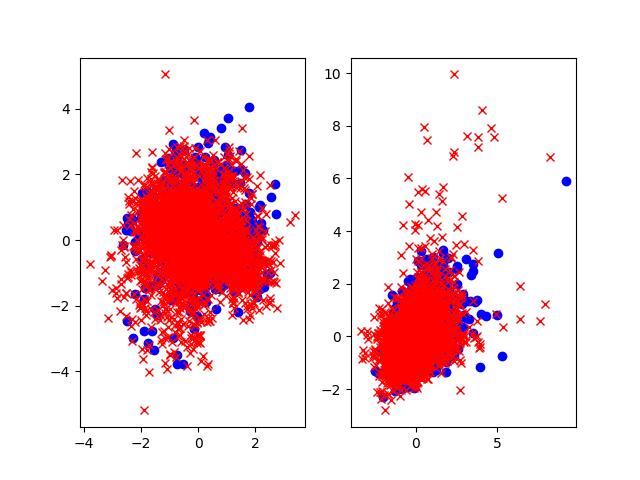

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs_wheeze = SequentialFeatureSelector(knn, n_features_to_select=2)
sfs_crackl = SequentialFeatureSelector(knn, n_features_to_select=2)

X_new_wheeze = sfs_wheeze.fit_transform(X_data_norm, Y_wheeze)
X_new_crackl = sfs_crackl.fit_transform(X_data_norm, Y_crackl)

%matplotlib notebook
# Definición de los puntos
X_wheeze_1 = X_new_wheeze[np.where(Y_wheeze == 1)]
X_wheeze_0 = X_new_wheeze[np.where(Y_wheeze == 0)]

X_crackl_1 = X_new_crackl[np.where(Y_crackl == 1)]
X_crackl_0 = X_new_crackl[np.where(Y_crackl == 0)]

plt.subplot(1,2,1)
plt.plot(X_wheeze_1[:, 0], X_wheeze_1[:, 1], color='blue', marker='o', linestyle=' ')
plt.plot(X_wheeze_0[:, 0], X_wheeze_0[:, 1], color='red', marker='x', linestyle=' ')

plt.subplot(1,2,2)
plt.plot(X_crackl_1[:, 0], X_crackl_1[:, 1], color='blue', marker='o', linestyle=' ')
plt.plot(X_crackl_0[:, 0], X_crackl_0[:, 1], color='red', marker='x', linestyle=' ')

plt.show()

# Testeando PCA

<IPython.core.display.Javascript object>


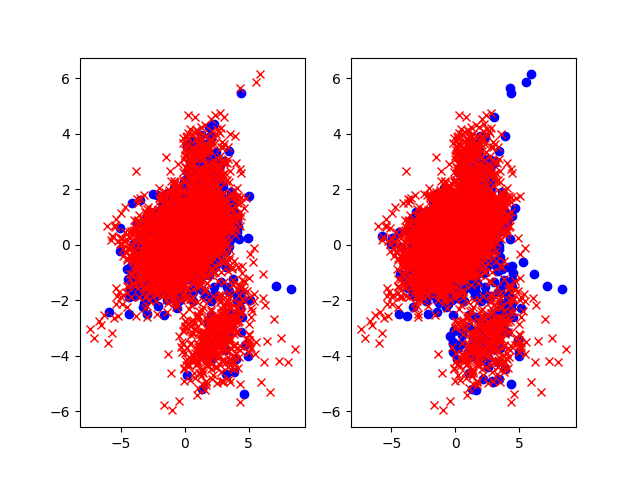

In [19]:
pca = PCA(n_components=10, random_state=0)
X_new = pca.fit_transform(X_data_norm)

%matplotlib notebook
# Definición de los puntos
X_wheeze_1 = X_new[np.where(Y_wheeze == 1)]
X_wheeze_0 = X_new[np.where(Y_wheeze == 0)]

X_crackl_1 = X_new[np.where(Y_crackl == 1)]
X_crackl_0 = X_new[np.where(Y_crackl == 0)]

plt.subplot(1,2,1)
plt.plot(X_wheeze_1[:, 0], X_wheeze_1[:, 1], color='blue', marker='o', linestyle=' ')
plt.plot(X_wheeze_0[:, 0], X_wheeze_0[:, 1], color='red', marker='x', linestyle=' ')

plt.subplot(1,2,2)
plt.plot(X_crackl_1[:, 0], X_crackl_1[:, 1], color='blue', marker='o', linestyle=' ')
plt.plot(X_crackl_0[:, 0], X_crackl_0[:, 1], color='red', marker='x', linestyle=' ')

plt.show()

In [76]:
X_new_wheeze[:][0].shape

(2,)

In [26]:
pca.explained_variance_ratio_

array([0.83624582, 0.0867782 , 0.03160611, 0.012985  , 0.00911586,
       0.00551731, 0.00410333, 0.00320352, 0.00214651, 0.00181272])

In [33]:
X = np.array([[4, 1, 2, 2],
     [1, 3, 9, 3],
     [5, 7, 5, 1]])

mu = X.mean(axis=1)
sigma = X.std(axis=1)

print(mu)
print(sigma)
print(((X.T - mu) / sigma).T)

[2.25 4.   4.5 ]
[1.08972474 3.         2.17944947]
[[ 1.60591014 -1.14707867 -0.22941573 -0.22941573]
 [-1.         -0.33333333  1.66666667 -0.33333333]
 [ 0.22941573  1.14707867  0.22941573 -1.60591014]]


In [36]:
(5 - 4.5) / 2.17944

0.22941673090335132

In [38]:
from sklearn.preprocessing import Normalizer
X = [[4, 1, 2, 2],
     [1, 3, 9, 3],
     [5, 7, 5, 1]]
transformer = Normalizer(norm='l1').fit(X)  # fit does nothing.
transformer

transformer.transform(X)

array([[0.44444444, 0.11111111, 0.22222222, 0.22222222],
       [0.0625    , 0.1875    , 0.5625    , 0.1875    ],
       [0.27777778, 0.38888889, 0.27777778, 0.05555556]])

In [39]:
import numpy as np
from sklearn import datasets
iris_X, iris_y = datasets.load_iris(return_X_y=True)
np.unique(iris_y)

array([0, 1, 2])

In [42]:
print(iris_X.shape)
print(iris_y.shape)
print(X_data.shape)
print(Y_wheeze.shape)

(150, 4)
(150,)
(6898, 20)
(6898,)
